this notebook makes sure that the rewritten GLM preprocessing pipelines works the same as before.

they are compared against files `glm_fitting_preprocessed_all.hdf5` and `glm_fitting_preprocessed_OT.hdf5` under `/private_data`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from tang_jcompneuro import glm_data_preprocessing
import h5py
import os.path
import numpy as np
from tang_jcompneuro import dir_dictionary
from tang_jcompneuro.io import load_image_dataset, neural_dataset_dict

In [3]:
def callback_show(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name, obj.shape)

def list_datasets():
    with h5py.File(os.path.join(dir_dictionary['private_data'], 'glm_fitting_preprocessed_all.hdf5'), 'r') as f:
        f.visititems(callback_show)

In [4]:
list_datasets()

MkA_Shape/half/0/None (9500, 800)
MkA_Shape/half/2/pca_random_sep (9500, 1032)
MkA_Shape/half/4/pca_random_sep (9500, 1032)
MkA_Shape/half/8/pca_random_sep (9500, 1032)
MkA_Shape/half/fpower/None (9500, 400)
MkA_Shape/half/linear/None (9500, 400)
MkA_Shape/y (9500, 1142)
MkE2_Shape/half/0/None (4605, 800)
MkE2_Shape/half/2/pca_random_sep (4605, 1032)
MkE2_Shape/half/4/pca_random_sep (4605, 1032)
MkE2_Shape/half/8/pca_random_sep (4605, 1032)
MkE2_Shape/half/fpower/None (4605, 400)
MkE2_Shape/half/linear/None (4605, 400)
MkE2_Shape/y (4605, 979)


In [5]:
key_mapping = {
    'linear': 'half/linear/None',
    'fpower': 'half/fpower/None',
    'gqm.2': 'half/2/pca_random_sep',
    'gqm.4': 'half/4/pca_random_sep',
    'gqm.8': 'half/8/pca_random_sep',
}


In [6]:
transformer_dict = glm_data_preprocessing.generate_transformer_dict(glm_data_preprocessing.max_total_dim_debug)

In [7]:
transformer_dict

{'fpower': (tang_jcompneuro.glm_data_preprocessing.FPGLMPreprocessor, {}),
 'gqm.2': (tang_jcompneuro.glm_data_preprocessing.GQMPreprocessor,
  {'locality': 2, 'max_total_dim': 1032}),
 'gqm.4': (tang_jcompneuro.glm_data_preprocessing.GQMPreprocessor,
  {'locality': 4, 'max_total_dim': 1032}),
 'gqm.8': (tang_jcompneuro.glm_data_preprocessing.GQMPreprocessor,
  {'locality': 8, 'max_total_dim': 1032}),
 'linear': (tang_jcompneuro.glm_data_preprocessing.VanillaGLMPreprocessor, {})}

In [8]:
# del transformer_dict['gqm.4']
# del transformer_dict['gqm.8']
# del transformer_dict['linear']
# del transformer_dict['fpower']

In [9]:
from sklearn.decomposition import PCA
from strflab.feature_transformation import quadratic_features
from scipy.stats import pearsonr

def legacy_trans(X, loc, new_trans=False):
    x_flat = X.reshape(len(X), -1)
    X_flat_q = quadratic_features(X, locality=(0, loc, loc))
    # let's check amount of variance contributed by X_flat and X_flat_q
    x_flat_all_this = np.concatenate((x_flat, X_flat_q), axis=1)
#     print(x_flat_all_this.shape, 'debug legacy')
    assert x_flat.shape[1] == 400
    size_x_linear = 400
    
    threshold_num_feature = 1032
    num_feature = x_flat_all_this.shape[1]

#     if num_feature <= threshold_num_feature:
#         # sometimes, X_flat_all_this.shape[0] can be small, so that in the end PCA have even
#         # smaller dims than original. That's fine. We don't do cross-dataset testing,
#         # and won't have any issue.
#         method_name = 'None'
#     else:
#         # do PCA.
#         method_name = 'pca_random_sep'
    
#     assert method_name == 'pca_random_sep'
    
#     if method_name == 'None':
#         explained_var = 1.0
#         pca_obj = PCA(svd_solver='full', n_components=None)
#         x_to_use = pca_obj.fit_transform(x_flat_all_this)
#         # remixing makes convergence faster.
#     elif method_name == 'pca_random_sep':
    pca_feature = min(num_feature - size_x_linear,
                      threshold_num_feature - size_x_linear,
                      x_flat_all_this.shape[0])
    assert pca_feature > 1
    pca_obj = PCA(svd_solver='randomized', n_components=pca_feature,
                  random_state=0)
    pca_sep_input = x_flat_all_this[:, size_x_linear:]
    
#     print(pca_sep_input.std(), 'legacy debug')
    
    if new_trans:
        # this is used in new transformer code.
        x_to_use = pca_obj.fit(pca_sep_input).transform(pca_sep_input)
    else:
        # this is used in original code.
        x_to_use = pca_obj.fit_transform(pca_sep_input)
#     print(x_to_use.std(), x_to_use.mean(), x_to_use2.std(), x_to_use2.mean(), 'legacy debug')
    
#     print(pearsonr(x_to_use.ravel(), x_to_use2.ravel())[0],
#          abs(x_to_use2-x_to_use).max())
    
    assert x_to_use.shape[1] == pca_feature
    explained_var = np.cumsum(pca_obj.explained_variance_ratio_)
    pca_sep_final_input = np.concatenate([x_flat_all_this[:, :size_x_linear],
                                          x_to_use], axis=1)
    
#     print(pca_sep_final_input1.std(), pca_sep_final_input1.mean(),
#           pca_sep_final_input2.std(), pca_sep_final_input2.mean(), 'legacy debug final output')
#     print(abs(pca_sep_final_input1-pca_sep_final_input2).max(), 'legacy debug final output')
    pca_obj = PCA(svd_solver='full', n_components=None)
    x_to_use = pca_obj.fit_transform(pca_sep_final_input)
    return x_to_use

In [10]:
def check_one_case(neural_dataset, subset):
    # load X in this neural dataset, using legacy method of resizing image.
    image_key = neural_dataset_dict[neural_dataset]['image_dataset_key']
    imageX = load_image_dataset(image_key, trans=True, scale=0.5, subset=subset, legacy_rescale=True)
    imageX_copy = imageX.copy()
    # then generate transformers
    #
    rng_state = np.random.RandomState(seed=0)
    
    for k, (class_this, kwargs) in transformer_dict.items():
        print(k)
        transformer_this: glm_data_preprocessing.GLMDataPreprocesser = class_this(**kwargs)
        transformer_this.get_transformer(imageX)
        explained_var_ratio_cumsum = np.cumsum(transformer_this.per_dim_var)
        X_transed = transformer_this.transform(imageX)
        # print(X_transed.shape)
        # assert explained_var_ratio_cumsum.shape == (X_transed.shape[1],)
        
        # compare with reference data.
        with h5py.File(os.path.join(dir_dictionary['private_data'], f'glm_fitting_preprocessed_{subset}.hdf5'), 'r') as f_ref:
            X_transed_ref = f_ref[f'{neural_dataset}/' + key_mapping[k]][...]
            explained_var_ratio_cumsum_ref = f_ref[f'{neural_dataset}/' + key_mapping[k]].attrs['explained_var']
        
        if k in {'linear', 'fpower'}:
            assert explained_var_ratio_cumsum_ref == 1.0
            assert abs(explained_var_ratio_cumsum[-1]-1) < 1e-6
        else:
            assert explained_var_ratio_cumsum_ref.shape == explained_var_ratio_cumsum.shape
            assert abs(explained_var_ratio_cumsum-explained_var_ratio_cumsum_ref).max() < 1e-6
        
        
        assert X_transed.shape == X_transed_ref.shape
        print(abs(X_transed_ref-X_transed).max())
        
        
        if not abs(X_transed_ref-X_transed).max() < 1e-6:
            assert 'gqm' in k
            print('NOT match! but possibly due to difference of fit.transform vs fit_transform')
            print(np.sum(abs(X_transed_ref-X_transed)>=1e-6))
            plt.close('all')
            plt.hist(X_transed_ref.ravel()-X_transed.ravel())
            plt.show()
            
            X_transed_legacy_oldtrans = legacy_trans(imageX, transformer_this.locality, False)
            assert X_transed.shape == X_transed_legacy_oldtrans.shape
            print('debug', abs(X_transed_legacy_oldtrans-X_transed_ref).max())
            assert abs(X_transed_legacy_oldtrans-X_transed_ref).max() < 1e-6
            
            X_transed_legacy_newtrans = legacy_trans(imageX, transformer_this.locality, True)
            assert X_transed.shape == X_transed_legacy_newtrans.shape
        
            print('debug', abs(X_transed_legacy_newtrans-X_transed).max())
            assert abs(X_transed_legacy_newtrans-X_transed).max() < 1e-6
        
        
        
#         assert abs(X_transed_ref-X_transed).max() < 1e-6
        # finally, (partially) make sure that I did not mistakenly use old data.
        perm_idx_this = rng_state.permutation(imageX.shape[0])
        
        X_transed_debug = np.empty_like(X_transed)
        
#         for idx_aaa, idx_this in enumerate(perm_idx_this):
#             if idx_aaa % 10 == 0:
#                 print(idx_aaa)
#             X_transed_debug[idx_this:idx_this+1] = transformer_this.transform(imageX[idx_this:idx_this+1])
        # break to two blocks
        X_transed_debug[perm_idx_this[:100]] =  transformer_this.transform(imageX[perm_idx_this[:100]])
        X_transed_debug[perm_idx_this[100:]] =  transformer_this.transform(imageX[perm_idx_this[100:]])
        
        assert X_transed.shape == X_transed_debug.shape
        print(abs(X_transed_debug-X_transed).max(), 'difference between one-batch and two-batch with permutation')
        # this is not zero probably due to blas lib.
        assert abs(X_transed_debug-X_transed).max() < 1e-6
        
        # finally, check statelessness.
        assert np.array_equal(transformer_this.transform(imageX_copy),
                              X_transed)

In [11]:
check_one_case('MkA_Shape', 'OT')

linear
9.85878045867e-14
7.1054273576e-15 difference between one-batch and two-batch with permutation
fpower
2.77555756156e-15
6.66133814775e-16 difference between one-batch and two-batch with permutation
gqm.2
3.22279009035e-12
1.7763568394e-14 difference between one-batch and two-batch with permutation
gqm.4
1.14841469667e-11
4.26325641456e-14 difference between one-batch and two-batch with permutation
gqm.8
1.83462134373e-11
4.26325641456e-14 difference between one-batch and two-batch with permutation


linear
2.02948768901e-13
3.5527136788e-15 difference between one-batch and two-batch with permutation
fpower
6.69603261727e-15
2.77555756156e-16 difference between one-batch and two-batch with permutation
gqm.2
2.65681496192
NOT match! but possibly due to difference of fit.transform vs fit_transform
9714840


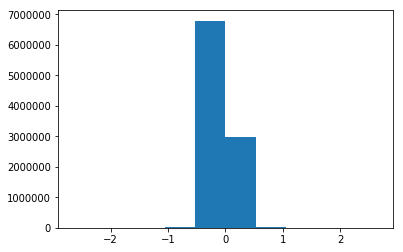

debug 0.0
debug 7.38964445191e-13
4.97379915032e-14 difference between one-batch and two-batch with permutation
gqm.4
7.61675028604e-11
3.5527136788e-14 difference between one-batch and two-batch with permutation
gqm.8
2.11581863141e-11
5.68434188608e-14 difference between one-batch and two-batch with permutation


In [12]:
check_one_case('MkA_Shape', 'all')

In [13]:
check_one_case('MkE2_Shape', 'OT')

linear
9.28146448587e-14
3.5527136788e-15 difference between one-batch and two-batch with permutation
fpower
1.49880108324e-15
5.55111512313e-16 difference between one-batch and two-batch with permutation
gqm.2
2.04103400847e-12
2.48689957516e-14 difference between one-batch and two-batch with permutation
gqm.4
9.85991843727e-12
2.48689957516e-14 difference between one-batch and two-batch with permutation
gqm.8
1.01152419774e-11
5.68434188608e-14 difference between one-batch and two-batch with permutation


In [14]:
check_one_case('MkE2_Shape', 'all')

linear
8.59937121511e-14
3.99680288865e-15 difference between one-batch and two-batch with permutation
fpower
2.12753457399e-15
2.22044604925e-16 difference between one-batch and two-batch with permutation
gqm.2
1.13438147764e-11
4.26325641456e-14 difference between one-batch and two-batch with permutation
gqm.4
2.46922482461e-11
3.5527136788e-14 difference between one-batch and two-batch with permutation
gqm.8
2.88049584185e-11
3.5527136788e-14 difference between one-batch and two-batch with permutation
